Test if the ShiftFormer can do more things.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mae_components_no_cls import *
import yaml
from PIL import Image,ImageDraw
from mae_dataset import get_miniImageNetDataLoader
import torch.optim as optim
import torch
from tqdm import tqdm
import os
import torch.nn as nn
import sys
import json
import utils
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import functional
from environment import StaticImgEnv

os.environ["CUDA_VISIBLE_DEVICES"] = '2, 3'

In [3]:
def read_yaml_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = read_yaml_config('config_shift.yaml')

def Transpose(img):
    img=torch.clip(img,0.0,1.0)
    test_img=functional.to_pil_image(img)

    return test_img

def draw_focus(img, x, y, patch_size):
    imdraw = ImageDraw.Draw(img)
    imdraw.rectangle((y,x,y+patch_size,x+patch_size), outline="blue")
    return img

In [4]:
dataset_root="COCOSearch18"
with open(os.path.join(dataset_root,
               'coco_search18_fixations_TP_train_split1.json'#'coco_search18_fixations_TP_train.json'
               )) as json_file:
    human_scanpaths_train = json.load(json_file)
    
with open(os.path.join(dataset_root,
               'coco_search18_fixations_TP_validation_split1.json'#'coco_search18_fixations_TP_validation.json'
               )) as json_file:
    human_scanpaths_valid = json.load(json_file)

'''
max=0
for dict in human_scanpaths_train:
    if dict['length']>=max:
        max=dict['length']
print(max)
'''

dataset=utils.COCOSearch18(json=human_scanpaths_train,root='COCOSearch18/images')

In [5]:
training_loader=DataLoader(dataset,batch_size=16, shuffle=True,num_workers=8)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
mae_encoder=MaskedViTEncoder(config, 224, 16, embed_dim=512, device=device).to(device)
shift_block=ShiftTransformer(config, img_size=224, patch_size=16, embed_dim=512, device=device).to(device)
mae_decoder=MaskedViTDecoder(config, 224, 16, encoder_embed_dim=512, decoder_embed_dim=256, device=device, masked_decoder_loss=True).to(device)

In [8]:
mae_encoder.load_state_dict(torch.load("./mae_log/no_cls/encoder_param.pth"),strict=False)
shift_block.load_state_dict(torch.load("./mae_log/shift_test/shift_param_r_1.pth"),strict=False)
mae_decoder.load_state_dict(torch.load("./mae_log/no_cls/decoder_param.pth"),strict=False)
mae_encoder.eval()
shift_block.train()
mae_decoder.eval()

MaskedViTDecoder(
  (encoder_to_decoder): Linear(in_features=512, out_features=256, bias=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=False)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
        (act2): GELU(approximate='none')
      )
    )
    (1): Block(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): L

In [9]:
#param_dict=[{'params':mae_encoder.parameters()},{'params':mae_decoder.parameters()}]
param_dict=[{'params':shift_block.parameters()}]
optimizer = optim.Adam(param_dict, lr=0.00005) #0.0001 for normal training, 0.00005 for finetuning

loss_fn=nn.CrossEntropyLoss()

#dataloader, memo = get_miniImageNetDataLoader(batch_size=4, img_size=224, shuffle=True)


In [10]:
env=StaticImgEnv(env_args=config['Environment'])

16
3 3


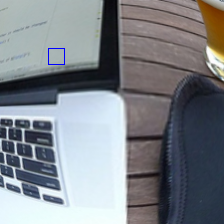

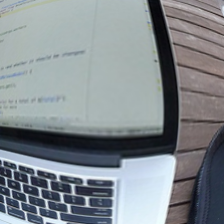

10 9


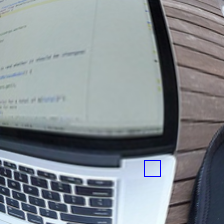

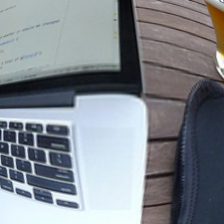

2 9


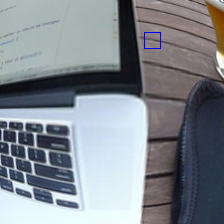

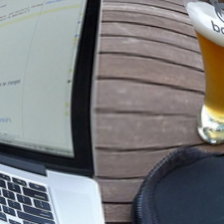

4 13


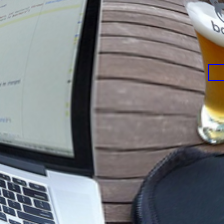

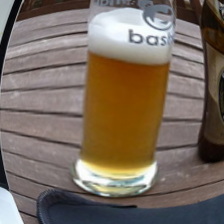

6 1


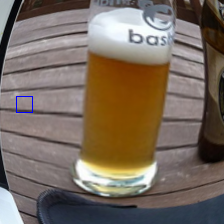

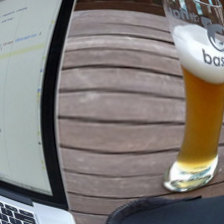

3 12


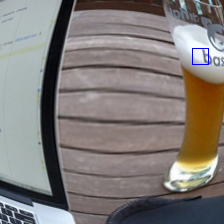

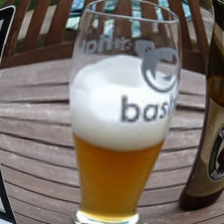

6 0


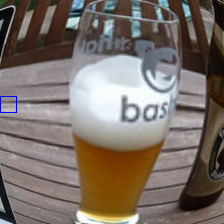

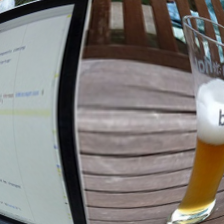

8 3


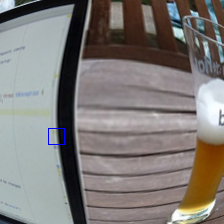

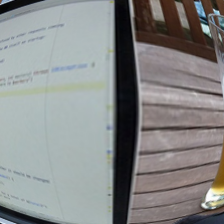

3 0


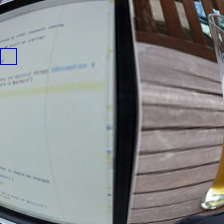

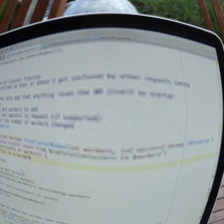

8 0


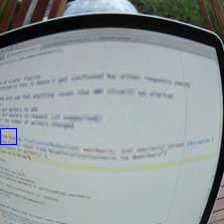

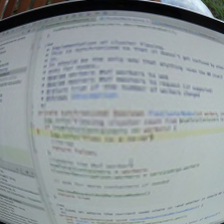

7 9


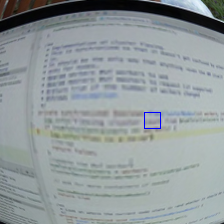

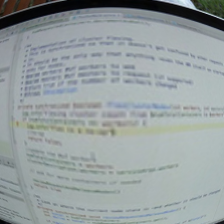

13 9


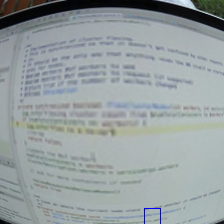

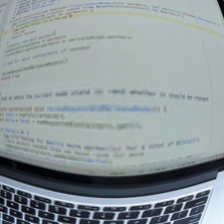

0 1


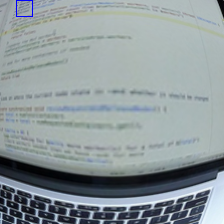

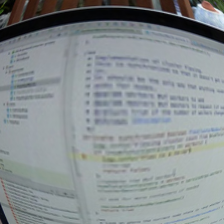

4 12


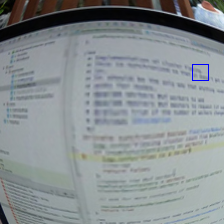

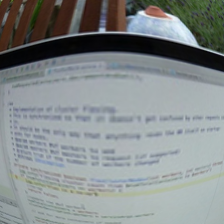

ValueError: 

In [29]:
mask_ratio = 0.0
max_traj_length = 15
act_patch=config['Environment']['radius']*2//config['Environment']['grid_size']
print(act_patch)

log_iter_freq = 50
imagine_freq = 2
checkpoint = 50
num_epoch = 50

log = []

for epoch in range(num_epoch):
    
    for idx, (img, target_id, fixations, correct, bbox) in enumerate(training_loader):

        batch_size = img.shape[0]
        #consistent with rl_rssm
        env.set_data(img,target_id, bbox) #bbox->target bbox [x,y,w,h]
        
        while env.step_id < max_traj_length-1:
            obs = env.observe()
            obs_before = Transpose(obs[0])
            
            #random step
            act_batch = torch.randint(0, config['Environment']['grid_size']**2, (batch_size,)).to(device)
            x=act_batch[0]//config['Environment']['grid_size']
            y=act_batch[0]%config['Environment']['grid_size']
            print(x.item(),y.item())
            display(draw_focus(obs_before,x*act_patch,y*act_patch,act_patch))
            obs, *_ = env.step(act_batch) #act_batch should shaped as [batch_size] scalars, and equals to x*grid_size + y
            display(Transpose(obs[0]))
            
        raise ValueError
            
        trajs=[]
        while env.step_id < max_traj_length-1:

            act_batch, log_prob, value, prob, epi_value = select_action((obs, env.target_id),
                                                    policy,
                                                    sample_action=True,
                                                    action_mask=None)#not implemented
            new_obs,reward,_,_,status=env.step(act_batch)
            epi_values.append(epi_value)
            actions.append(act_batch)
            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            states.append(new_obs)
            #status.append which I dont know what should status be

            #batch-process so I guess there no need to specify batch idx
            trajs={
                    'actions':torch.stack(actions),#[steps,batch]
                    'rewards':torch.stack(rewards),#[steps,batch]
                    'values':torch.stack(values),#[steps,batch]
                    'status':status.T[1:],#[steps,batch] truncate 1 empty step
                    'log_probs':torch.stack(log_probs),
                    'states':torch.stack(states),
                    'target_id':env.target_id, #[batch,]
                    'epi_values':torch.stack(epi_values)
            }            
        
        img=img.to(device)
        encoded, batch_mask = mae_encoder.forward_encoder(img, mask_ratio)
        
        #randomize action
        xy = shift_block.generate_shift_cat(encoded)

    
    for n_iter, (img, target) in enumerate(dataloader):
        img=img.to(device)
        encoded, batch_mask = mae_encoder.forward_encoder(img, mask_ratio)
        
        #randomize action
        xy = shift_block.generate_shift_cat(encoded)
        
        shifted = shift_block.forward_encoder(encoded, xy) #no cls_token
        reconstructed = mae_decoder.forward_decoder(shifted[:, :, 1:], batch_mask, vis=True) #assume shift complete, deprive assistant dim

        loss_rcs = mae_decoder.forward_shift_loss(imgs=img, pred=reconstructed, xy=xy)
        #loss_rcs = mae_decoder.forward_loss(imgs=img, pred=reconstructed, mask=batch_mask)

        #target=target.to(device)
        #target_pred = mae_encoder.forward(img)
        #loss_cls = loss_fn(target_pred, target)

        loss = loss_rcs #5*loss_cls + loss_rcs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():   
            if n_iter % log_iter_freq == 0:
                print(f"Epoch:{epoch} {n_iter}/{len(dataloader)} Loss:{loss.detach().item():.3f}")
                log.append(loss.detach().item())
                #print("ACC:",torch.sum(torch.argmax(target, dim=1)==torch.argmax(target_pred, dim=1))/target.shape[0])
            if n_iter % checkpoint == 0  and n_iter != 0:
                '''torch.save(mae_encoder.state_dict(), "./mae_log/shift_test/encoder_param_2.pth")'''
                #torch.save(mae_decoder.state_dict(), "./mae_log/shift_test/decoder_param.pth")
                torch.save(shift_block.state_dict(), "./mae_log/shift_test/shift_param_r_1.pth")
                torch.save(log, "./mae_log/shift_test/loss_r_1.pt")
            


In [ ]:
import numpy as np
np.random.seed(114)
x=np.expand_dims(np.random.randint(0,16,5),(0,1)).repeat(3,1).transpose(2,0,1)
y=np.expand_dims(np.random.randint(0,16,5),(0,1)).repeat(3,1).transpose(2,0,1)
xy=np.concatenate([x,y], axis=1)
print(xy.shape)


In [ ]:
np.random.seed(114)
#batch 20*20 512
shift_token = np.zeros((5,196,512))
shift_token[0,2,:]=1

x = np.random.randint(0,14,5)
y = np.random.randint(0,14,5)
xy=np.stack([x,y],axis=1)
print(xy.shape)
xy_dot=x*14 + y
xy_dot=np.tile(xy_dot,(1,196,1)).transpose()

print(xy_dot.shape)
print(xy)
print(shift_token[:,xy_dot].shape)